# **Challenge: Protein-Ligand Binding**

Molecular docking is a sophisticated computational technique designed to predict how a molecule, such as a drug (ligand), interacts with a target protein within the body. Proteins play a pivotal role in countless cellular processes, and the manner in which molecules bind to them can significantly influence their functionality. In molecular docking, researchers simulate the interaction between a protein's binding site—a specific region where the ligand can attach—and a potential ligand to assess their compatibility, akin to fitting pieces of a puzzle together. This "fit" is critical, as it determines the strength of the binding and whether the ligand can effectively activate, inhibit, or modulate the protein's function.

In this challenge, we will see how some ligands interact with a protein complex generated by a computer, and see what changes can be made that influcences the ability for that ligand to bind. You will have to look a lot at documentation for different python libraries this challenge, so be prepared!


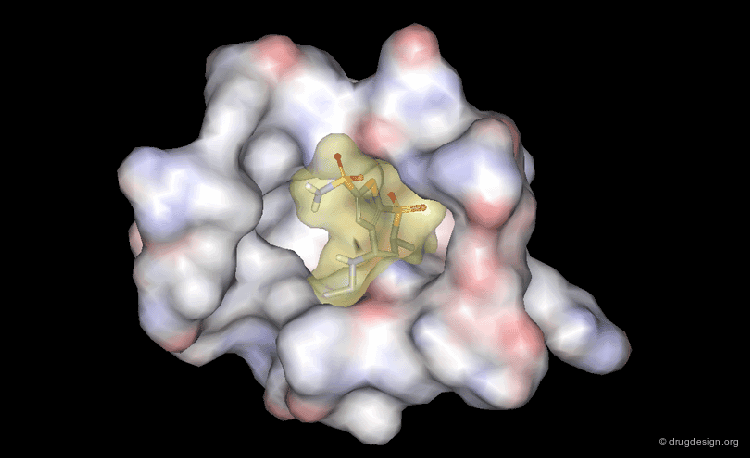


(GIF from https://www.drugdesign.org/chapters/molecular-docking/#introduction-to-computational-docking)

### Importing Tools

Before we can actually get to the challenge, we need to begin by importing all the packages we will be using.

Before we start, please change the runtime type to a GPU by going to Runtime --> Change Runtime Type --> GPU . If no GPU is available, continue with the default runtime type.

Feel free to ignore any `"The following packages were previously imported in this runtime... You must restart the runtime in order to use newly installed versions."` messages, you should be able to complete this colab without needing to restart.

In [ ]:
#Import conda environment
#This one has to restart the session after it runs once -- no worries if you have to reconnect!

# !pip install -q condacolab
# import condacolab
# condacolab.install()

In [ ]:
#need this to enable certain packages to work.
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
# %%capture #uncomment this line if you don't want to see specifics.
!apt-get install -y openbabel

!pip install rdkit MDAnalysis
!pip install Bio
!pip install pdb2pqr
!pip install prolif

#Package for molecular dynamics simulations
!wget https://sourceforge.net/projects/smina/files/smina.static/download -O smina.static
!chmod u+x smina.static

#Package for viewing
!pip install nglview==3.0.8
!pip install "ipywidgets>=7,<8"
!jupyter-nbextension enable nglview --py --sys-prefix

#protein prediction software
!pip install boltz

#Program for more molecular functions
# !conda install schrodinger::pymol


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libinchi1 libmaeparser1 libopenbabel7
The following NEW packages will be installed:
  libinchi1 libmaeparser1 libopenbabel7 openbabel
0 upgraded, 4 newly installed, 0 to remove and 34 not upgraded.
Need to get 3,903 kB of archives.
After this operation, 16.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libinchi1 amd64 1.03+dfsg-4 [455 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libmaeparser1 amd64 1.2.4-1build1 [88.2 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libopenbabel7 amd64 3.1.1+dfsg-6ubuntu5 [3,231 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 openbabel amd64 3.1.1+dfsg-6ubuntu5 [128 kB]
Fetched 3,903 kB in 3s (1,415 kB/s)
Selecting previously unselected package libinchi1.
(Reading database ... 126102 files and dire

## Task 1: **Generating the Complex**

[Boltz1](https://jclinic.mit.edu/boltz-1/) is a protein-prediction software created by the MIT Jameel Clinic that predicts what a protein structure looks like based on the sequence input. This can be used to generate your OWN proteins based off thin air!

The first thing is we want to generate the structure we would like to use in our Docking Challenge. We want to follow the documentation in the [Boltz1 Repository](https://github.com/jwohlwend/boltz/blob/2ba1f43067c2962347ef15e179ea5ab4dad91b30/docs/prediction.md) to know how to structure our input file.

Create a FASTA File `protein_w_ligand` that has three chains: A, B, and C, where A and B use the sequence described in `protein_chain` and C specifies a ligand with the ccd code **DMQ**.

In [ ]:
protein_chain = "PQVTLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKMIGGIGGFIKVRQYDQILIEICGHKAIGTVLVGPTPVNIIGRNLLTQIGATLNF"

boltz_input_file = open('protein_w_ligand.fasta','w')

#you can write what is in the fasta file through this string! Then it will be saved in the colab.
boltz_input_file.write(
    """
>A|protein|--use_msa_server
PQVTLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKMIGGIGGFIKVRQYDQILIEICGHKAIGTVLVGPTPVNIIGRNLLTQIGATLNF
>B|protein|--use_msa_server
PQVTLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKMIGGIGGFIKVRQYDQILIEICGHKAIGTVLVGPTPVNIIGRNLLTQIGATLNF
>C|ccd
DMQ
    """
)
boltz_input_file.close()




After writing your FASTA File, look at the [documentation](https://github.com/jwohlwend/boltz/blob/2ba1f43067c2962347ef15e179ea5ab4dad91b30/docs/prediction.md) again to run a one-line command that generates the protein. Be sure to  auto-generate the MSA and specify the output format as pdb.

In google colab, you can run items in the terminal by putting an exclamation point "!" before the command. We will then run this simple command to generate the protein. This command requires changing the runtime type (Go  to runtime --> change runtime type --> T4 GPU).

If there is no GPU available, you can download an example of what would be outputted by uncommenting the line in the cell below.



In [ ]:
## write the command prompt here!

!gdown 1oo6oAhcXizjWPC_VozLw-Lm-BB7RYh1M #run this command instead if no GPU is available.

Downloading...
From: https://drive.google.com/uc?id=1oo6oAhcXizjWPC_VozLw-Lm-BB7RYh1M
To: /content/protein_w_ligand_model_0.pdb
100% 128k/128k [00:00<00:00, 103MB/s]


Next, specify the directions for the output structure to boltz. Your pathway should start with `/content/`

In [ ]:
filename = 'protein_w_ligand'
pathway = "/content/protein_w_ligand_model_0.pdb"

If everything worked correctly, then running this block of text should give an output with an image similar to below! You should be able to move the view around to give different views of the protein-ligand complex, and select different atoms, etc.

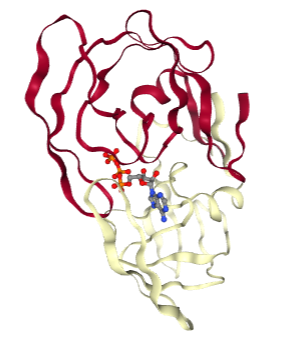

In [ ]:
import MDAnalysis as mda
import nglview as nv

u = mda.Universe(pathway)
view = nv.show_mdanalysis(u)
view

AttributeError: module 'numpy' has no attribute '_no_nep50_warning'

## Task 2: **Processing the Structure**

Now that we have our downloaded structure, we need to perform a few more tasks to analyze the bonds. First, use the mdanalysis package to select the atoms related to just the protein and the atoms related to just the ligands. Then, save those structures as separate pdb files. You will need to look at the mdanalysis documentation to know how to do this.

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
protein = # your code here
ligand = # your code here

### write code to write the protein and the ligands to the pdb ###


In order to actually utilize our docking tools, we need to process our data by adding hydgrogens. We can use the pdb2pqr package for that for our protein.

In [ ]:
! pdb2pqr --pdb-output=protein_h.pdb --pH=7.4 protein.pdb protein.pqr

INFO:PDB2PQR v3.7.1: biomolecular structure conversion software.
INFO:Please cite:  Jurrus E, et al.  Improvements to the APBS biomolecular solvation software suite.  Protein Sci 27 112-128 (2018).
INFO:Please cite:  Dolinsky TJ, et al.  PDB2PQR: expanding and upgrading automated preparation of biomolecular structures for molecular simulations. Nucleic Acids Res 35 W522-W525 (2007).
INFO:Checking and transforming input arguments.
INFO:Loading topology files.
INFO:Loading molecule: protein.pdb
ERROR:Error parsing line: invalid literal for int() with base 10: ''
ERROR:<REMARK     285 UNITARY VALUES FOR THE UNIT CELL AUTOMATICALLY SET>
ERROR:Truncating remaining errors for record type:REMARK

ERROR:['REMARK']
INFO:Setting up molecule.
INFO:Created biomolecule object with 198 residues and 1510 atoms.
INFO:Setting termini states for biomolecule chains.
INFO:Loading forcefield.
INFO:Loading hydrogen topology definitions.
INFO:Attempting to repair 2 missing atoms in biomolecule.
INFO:Added at

For our ligand, we can add hydrogens in another way. Specifically, we will get a reference ligand from an online database that ensures the correct bond order is maintained.

In [ ]:
import urllib
urllib.request.urlretrieve('https://www.ebi.ac.uk/pdbe/static/files/pdbechem_v2/DMQ_ideal.sdf','DMQ.sdf')

!obabel "DMQ.sdf" -O "ligand_h.pdb" --addh

1 molecule converted


This is easy enough to do, but we need to make sure that the ligand we find our reference in is in a similar position to the position we predict our ligand to be in based on Boltz1. Write code that corrects for this change in position in `ligand_h.pdb`. You can view whether the distance was corrected for by creating universes and viewing them on nglview.

## Task 3: **Evaluate Bonds**

Use the prolif package to evaluate the types of bonds that occur between the protein and our ligand of interest. You can use the Fingerprint().plot_lignetwork() function to accomplish this.

You should get an output that has a molecule attached to many bonds like this: 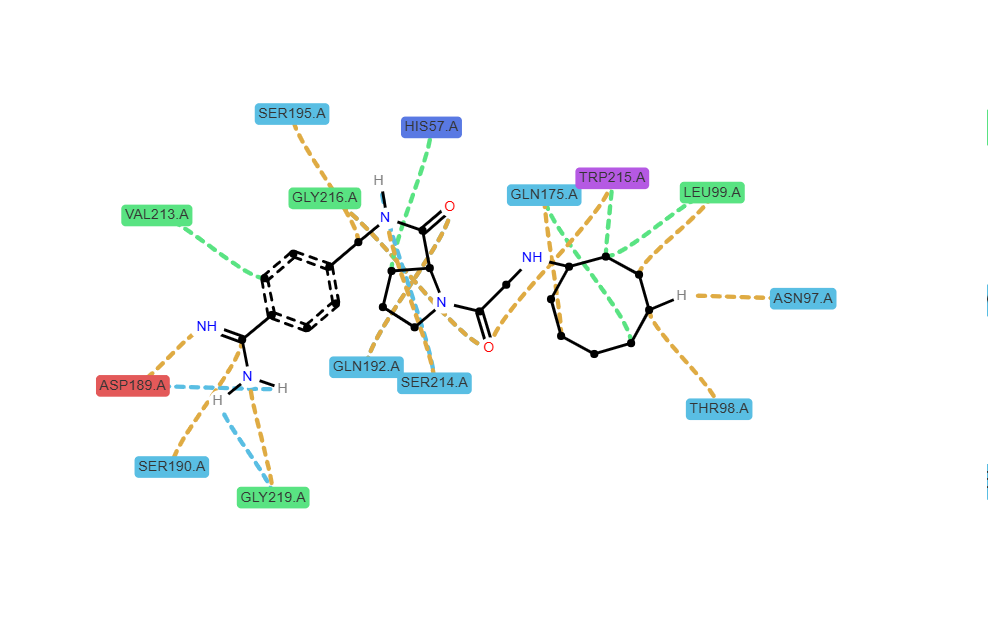

Once you do, give the names of all of the amino acids interacting with the pocket and the types of bonds. Please submit a set of lists in the form of the one letter amino acid code, the amino acid number, and the chain it is interacting with.


In [ ]:
import prolif as plf

### Your code here.



  0%|          | 0/1 [00:00<?, ?it/s]

## Task 4: Evaluating Ligand Affinity

Along with analyzing the types of bonds a ligand has with the protein, we can also predict the binding affinity of the protein, which is a measure how how strong a two molecules can bind to each other -- the lower number, the better.

We can use the molecular docking package Smina to accomplish this task.




In [ ]:
# -xr for rigid
!obabel protein.pdb -O protein.pdbqt -xr
!obabel ligand_h.pdb -O ligand_h.pdbqt

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is protein.pdb)

1 molecule converted
1 molecule converted


run the smina molecular dynamics training and see how everything squares out. Use an exhaustiveness of 16, and specify the seed to be `251455824`. Once you're done, submit the affinity number on the website!

Running this program may give us multiple "modes" which are confirmations that the ligand may take in the protein. We want to look at mode 1, which specifies the mode that binds most strongly to the protein.

In [ ]:
!obabel ligand-redocked.pdbqt -O ligand_redocked_conformers.pdb

!grep -A 100000 "MODEL 1" ligand_redocked_conformers.pdb | grep -B 100000 "ENDMDL" > ligand_redock.pdb







2 molecules converted


In [ ]:
ligand_redock = mda.Universe("ligand_redock.pdb")

view = nv.show_mdanalysis(mda.Merge(protein_h.atoms, ligand_redock.atoms))

view

NGLWidget()

Running this docking simulation may also influence the types of bonds that we see connected. Plot the ligand network again.

In [ ]:
# Write your code here

## Task 5: The Power Of Charge.

Let's see how changing amino acid residues affects the charge of our protein!

Change all the Aspartate Residues in the protein chain to Lysine residues. After that, run the smina docking with the same seed. How does this change affect bonds/the binding affinity?

Submit the number you get for mode 1 as your binding affinity!

In [ ]:
!boltz predict 'protein_w_ligand_new.fasta' --use_msa_server --override --output_format pdb

Checking input data.
Running predictions for 1 structure
Processing input data.
  0% 0/1 [00:00<?, ?it/s]Generating MSA for protein_w_ligand_new.fasta with 1 protein entities.

  0% 0/150 [00:00<?, ?it/s]
SUBMIT:   0% 0/150 [00:00<?, ?it/s]
COMPLETE:   0% 0/150 [00:00<?, ?it/s]
COMPLETE: 100% 150/150 [00:02<00:00, 68.04it/s] 
100% 1/1 [00:02<00:00,  2.52s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-01-31 21:45:25.312361: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738359925.644939   12950 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738359925.734665   12950 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuB

In [ ]:
filename = 'protein_w_ligand_new'
pathway = f"/content/boltz_results_{filename}/predictions/{filename}/{filename}_model_0.pdb"
# pathway = f"{filename}_model_0.pdb"

In [ ]:
u = mda.Universe(pathway)
view = nv.show_mdanalysis(u)
view

NGLWidget()

In [ ]:
# write your code here, feel free to use multiple code blocks

In [ ]:
! pdb2pqr --pdb-output=protein_h_new.pdb --pH=7.4 protein_new.pdb protein_new.pqr

INFO:PDB2PQR v3.7.1: biomolecular structure conversion software.
INFO:Please cite:  Jurrus E, et al.  Improvements to the APBS biomolecular solvation software suite.  Protein Sci 27 112-128 (2018).
INFO:Please cite:  Dolinsky TJ, et al.  PDB2PQR: expanding and upgrading automated preparation of biomolecular structures for molecular simulations. Nucleic Acids Res 35 W522-W525 (2007).
INFO:Checking and transforming input arguments.
INFO:Loading topology files.
INFO:Loading molecule: protein_new.pdb
ERROR:Error parsing line: invalid literal for int() with base 10: ''
ERROR:<REMARK     285 UNITARY VALUES FOR THE UNIT CELL AUTOMATICALLY SET>
ERROR:Truncating remaining errors for record type:REMARK

ERROR:['REMARK']
INFO:Setting up molecule.
INFO:Created biomolecule object with 198 residues and 1510 atoms.
INFO:Setting termini states for biomolecule chains.
INFO:Loading forcefield.
INFO:Loading hydrogen topology definitions.
INFO:Attempting to repair 2 missing atoms in biomolecule.
INFO:Adde